# Actors ... What they are, what they can do and why are they relevant

## Overview

* I'll cover the general nature of the problems they were designed for
* Give a quick outline of what they are
* Provide some further examples and references:
 

## The law makers - Amdahl and Moore

A couple of big computer theories come into play.  

1. Moore's Law(s) - improvements in computing power

2. Amdahl's Law - constraints re parallelisation gains.

_Refs_:

* (https://www.pcworld.com/article/2042256/scientist-out-to-break-amdahls-law.html)

### Moore's First Law

> Moore's law is the observation that the number of transistors in a dense integrated circuit doubles approximately every two years. 

![](http://www.extremetech.com/wp-content/uploads/2015/04/MooresLaw2.png)

Ref: http://www.extremetech.com/wp-content/uploads/2015/04/MooresLaw2.png

### Moore's Second Law

> As the cost of computer power to the consumer falls, the cost for producers to fulfill Moore's law follows an opposite trend: R&D, manufacturing, and test costs have increased steadily with each new generation of chips. Rising manufacturing costs are an important consideration for the sustaining of Moore's law.[39] This had led to the formulation of Moore's second law, also called Rock's law, which is that the capital cost of a semiconductor fab also increases exponentially over time.

Ref: https://en.wikipedia.org/wiki/Moore%27s_law

Moore's Law and competing forces both in Physics (law 1) and Economics (law 2) imply better concurrency models will offer the most strategic route to improved performance.

### Amdahl's law

> Evolution according to Amdahl's law of the theoretical speedup in latency of the execution of a program in function of the number of processors executing it, for different values of p. The speedup is limited by the serial part of the program. For example, ** if 95% of the program can be parallelized, the theoretical maximum speedup using parallel computing would be 20 times **.

Ref: https://en.wikipedia.org/wiki/Amdahl%27s_law

This notebook provides insight into why more efficient concurrency models are relevant:

1. They enable us to do more work with more resources (i.e. **improved scalability**).
2. They enable us to achieve the same with less resources (i.e. **improved efficiency**).
3. They enable us to reduce latencies (i.e. **improved performance**).

Understanding the degree to which a problem can be parallelised and the pipeline bottlenecks is the key.

Armdahl's law: 

$S_\text{latency}(s) = \frac 1 {(1 - p) + \frac p s}$

The following is an interactive simulation showing how the potential gains of increasing computation resource is directly dependent upon the degree of theoretical parallelization of the solution architecture.

<HR>

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output
from IPython.display import display
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

def armdahl(p, proc_count):
    return [1 / ((1-p) + p / float(n)) for n in range(1, proc_count + 1)]

wdg_h = widgets.HTML("<b>Armdahl's Law</b>")

wdg_p = widgets.FloatSlider(
    value=1,
    min=0,
    max=1.0,
    step=0.01,
    description='p:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

wdg_i = widgets.IntSlider(
    value=256,
    min=1,
    max=256,
    step=1,
    description='Proc Count:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

out = widgets.Output()

def handle_slider_change(change):
    global df
    df = pd.Series(armdahl(wdg_p.value, wdg_i.value))
    ax = df.plot(title="Armdahl's Law", )
    ax.set_xlabel("Available Processes / Nodes")
    ax.set_ylabel("Speedup")
    # ax2 = df.diff().plot()
    
    with out:
        display(plt.show())
        # display(df.to_frame().head())
        clear_output(wait=True)

wdg_p.observe(handle_slider_change, names='value')
wdg_i.observe(handle_slider_change, names='value')

items = [wdg_h, wdg_i, wdg_p, out]
display(widgets.VBox(items))

Depressingly the interactive model shows that unless software is designed specifically with concurrency in mind the additional performance obtained by adding additional resources to a problem becomes negligable surprisingly quickly with rapidly decreasing marginal returns.

The visualization helps intuition regarding when it may be worth adding more boxes and when this may be a waste of money with little/no tangible return.

In addition the costs associated with infrastructure (initial and ongoing) should be seriously considered.

## Concurrency / Complexity Continuum

Before considering actors some appreciation of where they sit in the bigger picture is needed. One abstraction is to consider their placement on a complexity continuum ranging from the most simple to the most complex. 

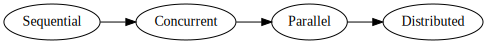

In [19]:
from graphviz import Source

Source('digraph "Complexity" { rankdir=LR; Sequential -> Concurrent -> Parallel -> Distributed }')

The further we go to the right of the diagram the harder this stuff becomes and the more rigourous the underlying thinking needs to be.  [Ref Lamport Video]

### Using juggling as an example:

1. A ball being thrown single handedly up and down is **sequential**.  1 process (hand) is executing 1 task (throwing the ball) at a time.

2. Two balls being juggled single handedly is **concurrent**.  1 process (hand) is executing 2 task (throwing 2 balls) 'at the same time' by switching between each task.

3. Two balls being thrown in the air using both hands is an example of **parallel** execution.  

4. Juggling with more than one ball in both hands is an example of both **parallel and concurrent** execution.

5. Juggling with more than one person demonstrates **distributed, parallel and concurrent execution**.

<HR>

## What are the options

We're really talking about Concurrency Models.  One abstraction is shown below: 

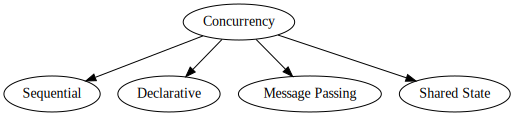

In [20]:
from graphviz import Source, Digraph

dot = Digraph(comment='Concurrency Models')
dot.node('C', 'Concurrency')
dot.node('S', 'Sequential')
dot.node('D', 'Declarative')
dot.node('M', 'Message Passing')
dot.node('T', 'Shared State')

dot.edges([('C', 'S'), ('C','D'), ('C', 'M'), ('C', 'T')])
dot

Ref :Van Roy 04

<HR>

## Actors

Actors fall within the **Message Passing** approach.

The theory was first suggested by Carl Hewitt in the 1970's (https://en.wikipedia.org/wiki/Actor_model).  His work was developed by Gul Agha in the mid 80's (https://en.wikipedia.org/wiki/Gul_Agha_(computer_scientist)) and shortly after this became implemented in Erlang. More recently Erlang has been the inspiration for Akka with implementations on both the JVM (Java / Scala) and CLR (C# / F#).

Actors can be viewed broadly as constrained instantiated objects executing in their own process space and can either be stateful or stateless.

Each actor has it's own mailbox and isolated internal state.  An actor can talk to the outside world but it can only communicate to other actors by sending immutable messages.

### What can an actor do 

1. Send messages to other actors.
2. Create / kill other actors.
3. Change their own state & internal behaviour
4. Communicate with the 'outside world'

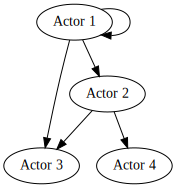

In [14]:
from graphviz import Source, Digraph

dot = Digraph(comment='Actor Abstraction')
dot.node('A1', 'Actor 1')
dot.node('A2', 'Actor 2')
dot.node('A3', 'Actor 3')
dot.node('A4', 'Actor 4')

dot.edges([('A1', 'A2'), ('A1', 'A1'), ('A1','A3'), ('A2', 'A3'), ('A2', 'A4')])
dot

## Additional Actor Framework functionality

To support the use of actors to build robust enterprise systems an actor framework will usually provide a varient of the following:

1. Supervision framework - each node/actor is monitored with defined failure behaviour.
2. Service location / discovery - lookup capability to locate an actor based on id.
3. Routing / placement - the ability to specify where an actor should be created (i.e. which node in a cluster).

### So what !?

Although this sounds limited **it enables the sharing of state it removes the need for distributed locks, mutexes etc**. As a side effect they avoid all of the unwanted complex family of bugs associated with them.

A positive side effect is that the journey from sequential -> distributed becomes much easier.  In theory with **location transparency** around where and how the code is executed.

Improving how we think about concurrency has **significant impacts on cost, efficiency and performance.**

The functionality provided by the actor framework can be a quick way of delivering **high availability systems with minimal code.**

<HR>

## Demo

#### Highly Concurrent Metronome / Heartbeat Service

This is an example scala / Akka service that creates an arbitrary number of actors to *keep time*.  Each of these actors have been called $Fixtures$ in the example to avoid naming confusion.

Three variables can be passed into the actor system on execution - the number of actors ($n$), a tick interval ($t_1$) and a tock interval ($t_2$).  The actor system creates $n$ actors on startup.

Each actor will send itself a tick message after $t_1$ and a tock message after $t_2$ and print a message to the system terminal on receipt of each message.

Logging to the terminal is an arbitrary piece of code, it could be replaced with code to call external API's, pull from message queues, carry out sampling or debouncing etc.

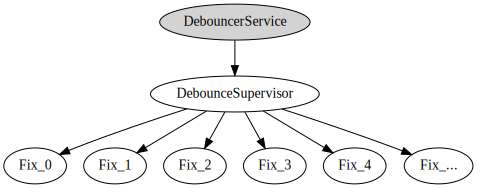

In [18]:
from graphviz import Digraph

dot = Digraph(comment='Debouncing Service')

dot.node('DebouncerService', style='filled')
dot.node('DebounceSupervisor')
dot.edge('DebouncerService', 'DebounceSupervisor')
for i in range(5):
    dot.node("Fix_{}".format(i))
    dot.edge('DebounceSupervisor', "Fix_{}".format(i))

dot.node("Fix_...".format(i))
dot.edge('DebounceSupervisor', "Fix_...".format(i))
dot

### Service
```scala
import akka.actor.{ActorRef, ActorSystem, Props}
import com.typesafe.config.{Config, ConfigFactory}

object DebouncerService {
  import Messages._

  private var system: Option[ActorSystem] = None

  def main(args: Array[String]) = {
    val config: Config = ConfigFactory.load()
    val numfixtures: Int = config.getInt("app.num_fixtures")
    val tickSize: Int = config.getInt("app.tick_size")
    val tockSize: Int = config.getInt("app.tock_size")

    val system  = ActorSystem("DebouncerService")
    val debounceSupervisorRef: ActorRef = system.actorOf(Props[DebounceSupervisor], "DebounceSupervisor")

    for (a <- 1 to numfixtures) {
      var actorName = s"Fixture-${a}"
      debounceSupervisorRef ! AddFixture(actorName, tickSize, tockSize)
    }
  }
}```

### Supervisor
```scala
import akka.actor.{Actor, ActorSystem, Props}
import Messages._

class DebounceSupervisor extends Actor{

  val system  = ActorSystem("DebouncerService")

  def receive = {
    case AddFixture(key, tickSize, tockSize) => {
      system.actorOf(Props(new FixtureDebouncer(tickSize, tockSize)), name=key)
    }
  }
}
```

### Fixture Debouncer

```scala
import akka.actor.FSM
import scala.concurrent.duration._

sealed trait State
case object Active extends State

sealed trait Data
case class SData(intCount: Int) extends Data

class FixtureDebouncer(tick_size: Int, tock_size: Int) extends FSM[State, Data] {

  startWith (Active, SData(0))

  when (Active, stateTimeout = tick_size second) {
    case Event(StateTimeout, SData(i)) =>
      if (i > 0) {
        log.info(s"${self.path.name}: Tick ${i}")
        goto(Active) using SData(i-tick_size)
      }
      else {
        log.info(s"${self.path.name}: Tock ${i}")
        goto(Active) using SData(tock_size)
      }
  }

  initialize()
}
```

### Execution
```bash
sbt -Dapp.num_fixtures=1000 -Dapp.tock_size=10 -Dapp.tick_size=1 -Dakka.loglevel=info run
```